In [110]:
import xgboost
from catboost import CatBoostClassifier
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

датасет про на аутистов https://archive.ics.uci.edu/ml/datasets/Autism+Screening+Adult

A1_Score - A10_Score - ответы на вопросы.
@relation adult-weka.filters.unsupervised.attribute.NumericToNominal-Rfirst-10

@attribute A1_Score {0,1}

@attribute A2_Score {0,1}

@attribute A3_Score {0,1}

@attribute A4_Score {0,1}

@attribute A5_Score {0,1}

@attribute A6_Score {0,1}

@attribute A7_Score {0,1}

@attribute A8_Score {0,1}

@attribute A9_Score {0,1}

@attribute A10_Score {0,1}

@attribute age numeric

@attribute gender {f,m}

@attribute ethnicity {White-European,Latino,Others,Black,Asian,'Middle Eastern ',Pasifika,'South Asian',Hispanic,Turkish,others}

@attribute jundice {no,yes}

@attribute austim {no,yes}

@attribute contry_of_res {'United States',Brazil,Spain,Egypt,'New Zealand',Bahamas,Burundi,Austria,Argentina,Jordan,Ireland,'United Arab Emirates',Afghanistan,Lebanon,'United Kingdom','South Africa',Italy,Pakistan,Bangladesh,Chile,France,China,Australia,Canada,'Saudi Arabia',Netherlands,Romania,Sweden,Tonga,Oman,India,Philippines,'Sri Lanka','Sierra Leone',Ethiopia,'Viet Nam',Iran,'Costa Rica',Germany,Mexico,Russia,Armenia,Iceland,Nicaragua,'Hong Kong',Japan,Ukraine,Kazakhstan,AmericanSamoa,Uruguay,Serbia,Portugal,Malaysia,Ecuador,Niger,Belgium,Bolivia,Aruba,Finland,Turkey,Nepal,Indonesia,Angola,Azerbaijan,Iraq,'Czech Republic',Cyprus}

@attribute used_app_before {no,yes}

@attribute result numeric

@attribute age_desc {'18 and more'}

@attribute relation {Self,Parent,'Health care professional',Relative,Others}

@attribute Class/ASD {NO,YES}

In [111]:
df = pd.read_csv("Autism-Adult-Data.arff")
df.head(3)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,country_of_res,used_up_before,result,age_desc,relation,class_ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES


In [112]:
df['class_ASD'].value_counts()

NO     515
YES    189
Name: class_ASD, dtype: int64

In [113]:
df.shape

(704, 21)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   A1_Score        704 non-null    int64 
 1   A2_Score        704 non-null    int64 
 2   A3_Score        704 non-null    int64 
 3   A4_Score        704 non-null    int64 
 4   A5_Score        704 non-null    int64 
 5   A6_Score        704 non-null    int64 
 6   A7_Score        704 non-null    int64 
 7   A8_Score        704 non-null    int64 
 8   A9_Score        704 non-null    int64 
 9   A10_Score       704 non-null    int64 
 10  age             704 non-null    object
 11  gender          704 non-null    object
 12  ethnicity       704 non-null    object
 13  jundice         704 non-null    object
 14  austim          704 non-null    object
 15  country_of_res  704 non-null    object
 16  used_up_before  704 non-null    object
 17  result          704 non-null    int64 
 18  age_desc  

In [115]:
df.describe(include='all',).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
A1_Score,704,NaN,NaN,NaN,0.721591,0.448535,0,0,1,1,1
A2_Score,704,NaN,NaN,NaN,0.453125,0.498152,0,0,0,1,1
A3_Score,704,NaN,NaN,NaN,0.457386,0.498535,0,0,0,1,1
A4_Score,704,NaN,NaN,NaN,0.495739,0.500337,0,0,0,1,1
A5_Score,704,NaN,NaN,NaN,0.49858,0.500353,0,0,0,1,1
A6_Score,704,NaN,NaN,NaN,0.284091,0.451301,0,0,0,1,1
A7_Score,704,NaN,NaN,NaN,0.417614,0.493516,0,0,0,1,1
A8_Score,704,NaN,NaN,NaN,0.649148,0.477576,0,0,1,1,1
A9_Score,704,NaN,NaN,NaN,0.323864,0.468281,0,0,0,1,1
A10_Score,704,NaN,NaN,NaN,0.573864,0.494866,0,0,1,1,1


пропусков нету, учитывая что мы будем использовать CatBoost, c катигориальными признаками делать ничего не нужно, только указать их.  Я не виноват что такой датасет=)) и так там не просто выбрать что-то подходящее что можно интерпритировать.

In [116]:
categorical = ['age','gender','ethnicity','jundice','austim','country_of_res','used_up_before','age_desc','relation']
df.pop('result') # удалим результат теста, так как он дает 100% точность, не очень хорошо для визуализации.

0      6
1      5
2      8
3      6
4      2
      ..
699    7
700    3
701    7
702    6
703    8
Name: result, Length: 704, dtype: int64

In [117]:
df['class_ASD'].replace({'YES': 1, 'NO':0},inplace=True)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state=1)

In [120]:
model = CatBoostClassifier()
model.fit(X_train, y_train,cat_features=categorical, verbose=False)

In [121]:
y_pred = model.predict(X_test)

In [122]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.9596989966555185


In [123]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [134]:
shap.force_plot(explainer.expected_value, shap_values[200,:], X_train.iloc[200,:])

вроде тут все просто интерпритируется, ответ на вопрос  0 или 1 дает нам смещение в опеределенную сторону 'k' или 'от' целевого класса, в этих двух примерах явно был получен разный ответ на вопрос A6 в одном случае это повлияло на смещение в сторону аутизма, а в другом слчае наоборот.

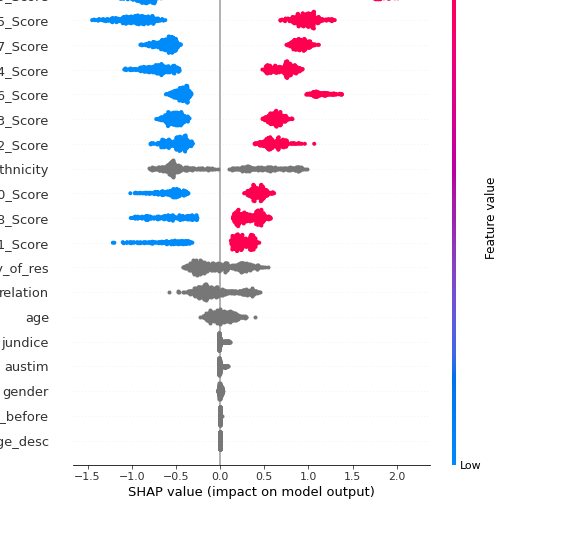

In [125]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Результаты выглядят так что любой из заданых вопросов один может давать правильный результат. Видимо категориальные признаки были изменены CatBoost во чтото другое, поэтому показаны серым. Для того что бы их можно было интерпритировать цветом. Видимо нужно их переделывать в OHE.

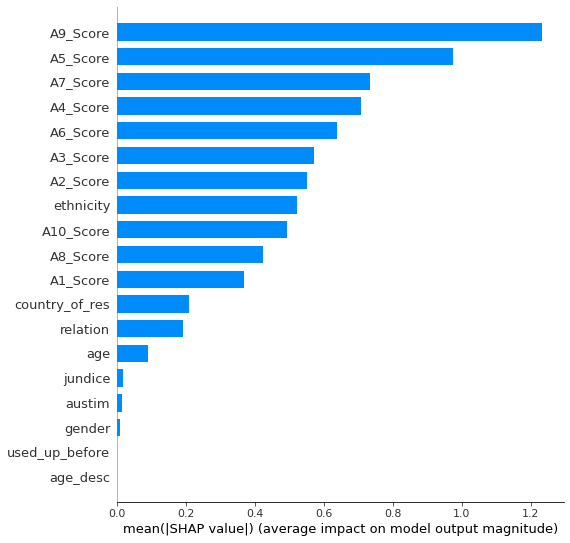

In [126]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

вопросы оказывают наибольшее влияние. но определеную роль играет этничность.

In [132]:
n =  X_train.shape[0] // 10 #top 10%
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

Тут мы видим как изменяются ответы на вопросы по мере перехода от одного класса к другому. Очень похоже на то что вопросы подобраны таким образом что вечая на них 1 мы становимся аутистом а отвечая 0 наоборот. Понятно что скорей всего в исследовании небыло так, что это был просто чек лист на аутизм. Скорей всего вопросы как то мисковались.